In [25]:
import argparse
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from os.path import join, isdir
import torch.nn.functional as F
import torch

from mypath import Path
from dataloaders import make_data_loader
from dataloaders.custom_transforms import denormalizeimage
from dataloaders.utils import decode_segmap
from dataloaders import custom_transforms as tr
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.saver import Saver
import time
import multiprocessing

from DenseCRFLoss import DenseCRFLoss
from dataloaders.datasets.pascal import VOCSegmentation
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from utils.metrics import Evaluator
from sklearn.metrics import jaccard_score
from skimage.measure import shannon_entropy
import scipy
import json

In [2]:
def decode_segmap(label_mask, plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """
    n_classes = 21
    label_colours = get_pascal_labels()

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb
def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                       [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                       [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                       [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                       [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                       [0, 64, 128]])

In [3]:
inv_tr = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [4]:
n_class = 21
backbone = 'mobilenet'
gpu_ids = [3]
device = torch.device(f'cuda:{gpu_ids[0]}')
checkpoint = '/home/jacob/scribblegen/rloss/pytorch/pytorch-deeplab_v3_plus/run/pascal/deeplab-mobilenet/rloss_60/checkpoint_epoch_60.pth.tar'

model = DeepLab(num_classes=n_class,
                    backbone=backbone,
                    output_stride=16,
                    sync_bn=False,
                    freeze_bn=False)
    
# Using cuda
model = torch.nn.DataParallel(model, device_ids=gpu_ids)
patch_replication_callback(model)
model = model.to(device)

# load checkpoint
if not os.path.isfile(checkpoint):
    raise RuntimeError("=> no checkpoint found at '{}'" .format(checkpoint))
checkpoint = torch.load(checkpoint, map_location=f"cuda:{gpu_ids[0]}")
model.module.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
best_pred = checkpoint['best_pred']
print("=> loaded checkpoint '{}' (epoch {}) best_pred {}"
        .format(checkpoint, checkpoint['epoch'], best_pred))

model.eval()

=> loaded checkpoint '{'epoch': 60, 'state_dict': OrderedDict([('backbone.features.0.0.weight', tensor([[[[ 2.2854e-02,  5.2323e-03, -3.1764e-02],
          [-4.0232e-02,  8.2175e-02,  3.1613e-01],
          [ 4.8721e-03, -8.3391e-02, -2.7083e-01]],

         [[ 4.3033e-02,  4.9221e-04, -1.6987e-02],
          [-7.3499e-02,  1.4997e-01,  5.2791e-01],
          [ 3.7023e-02, -1.4996e-01, -4.6185e-01]],

         [[ 8.6931e-03,  2.1923e-02, -9.0674e-03],
          [-9.0890e-05,  3.0424e-02,  1.6387e-01],
          [-1.9272e-02, -3.2473e-02, -1.6307e-01]]],


        [[[-2.3370e-03,  2.0481e-03, -3.9855e-03],
          [ 3.0176e-03, -5.2678e-03, -1.0056e-02],
          [-1.4750e-03, -7.2684e-04, -1.8268e-03]],

         [[-1.2555e-04,  3.1084e-03, -9.2765e-04],
          [ 2.9703e-03, -1.1650e-02, -1.8892e-02],
          [ 5.2724e-06, -5.7979e-04, -2.2188e-03]],

         [[-2.4077e-03,  2.4952e-03,  9.0917e-04],
          [ 1.9711e-03, -7.6987e-03, -1.0990e-02],
          [ 1.5014e-03,  

DataParallel(
  (module): DeepLab(
    (backbone): MobileNetV2(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm

In [5]:
def get_miou(y_true, y_pred, n_class):
    mask = (y_true >= 0) & (y_true < n_class)
    label = n_class * y_true[mask].astype('int') + y_pred[mask]
    count = np.bincount(label, minlength=n_class**2)
    confusion_matrix = count.reshape(n_class, n_class)
    MIoU = np.diag(confusion_matrix) / (
                np.sum(confusion_matrix, axis=1) + np.sum(confusion_matrix, axis=0) -
                np.diag(confusion_matrix))
    MIoU = np.nanmean(MIoU)
    return MIoU

In [6]:
class temp:
    base_size = 513
    crop_size = 513
    scribbles = True
    aug_data = 'synth-only'
    aug_ratio = 8
    aug_use_all = False
args = temp()

split = 'train'
voc = VOCSegmentation(args, split=split, debug=True)
dataloader = DataLoader(voc, batch_size=128, num_workers=16)
evaluator = Evaluator(n_class)

np.seterr(divide='ignore', invalid='ignore')
threshs = [0.4, 0.6, 0.8]
percents = [{} for _ in threshs] # list [name -> list [percentages over thresh]]

ious = []
preds = []
scribbles = []
targets = []
imgs = []
names = []

c = 0

for data in tqdm(dataloader):
    if split == 'train':
        img, scribble, target, name, dataset = data['image'], data['label'], data['full_label'], data['id'], data['dataset']
        target[target==254]=255
    elif split == 'val':
        img, scribble = data['image'], data['label']
    img.to(gpu_ids[0])
    with torch.no_grad():
        output = model(img)
    dist = F.softmax(output.cpu(), dim=1)
    dist = dist.moveaxis(1, 3)
    entropies = scipy.stats.entropy(dist.numpy(), axis=3)

    for t_i, t in enumerate(threshs):
        for i in range(len(entropies)):
            if name[i] not in percents[t_i]:
                percents[t_i][name[i]] = [-1 for _ in range(8)]
            percents[t_i][name[i]][dataset[i] - 1] = (entropies[i] > t).sum() / (513 * 513)

    # scribble = scribble.numpy()
    # pred = output.cpu().numpy()
    # pred = np.argmax(pred, axis=1)
    # evaluator.add_batch(scribble, pred)

    # for i in range(len(target)):
    #     ious.append(get_miou(scribble[i].cpu().numpy(), pred[i], 21))
    #     #ious.append(jaccard_score(scribble[i].flatten(), pred[i].flatten(), labels=list(range(21)), average='micro'))
    #     preds.append(pred[i])
    #     scribbles.append(scribble[i].cpu().numpy())
    #     targets.append(target[i])
    #     imgs.append(img[i].cpu().numpy())
    #     names.append(name[i])
    #if c == 20:
    #    break
    c += 1

Number of images in train: 84656 (0 are real)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 662/662 [1:35:17<00:00,  8.64s/it]


  0%|                                                                                                                              | 0/662 [00:00<?, ?it/s]

 11%|████████████▏                                                                                                      | 70/662 [10:00<1:23:41,  8.48s/it]

In [28]:
out_dict = [{} for _ in range(len(threshs))]
for i in range(len(threshs)):
    for k, v in percents[i].items():
        out_dict[i][k] = (np.argsort(v) + 1).tolist()

In [32]:
with open('best_synthetic_0_8.json', 'w') as f:
    json.dump(out_dict[2], f)

In [29]:
out_dict[0]

{'2007_000032': [5, 2, 4, 6, 3, 1, 7, 8],
 '2007_000039': [1, 5, 4, 6, 7, 2, 8, 3],
 '2007_000063': [7, 5, 8, 3, 2, 1, 6, 4],
 '2007_000068': [4, 6, 8, 7, 5, 1, 3, 2],
 '2007_000121': [6, 5, 2, 8, 7, 3, 1, 4],
 '2007_000170': [8, 4, 1, 5, 6, 2, 3, 7],
 '2007_000241': [3, 2, 1, 6, 5, 7, 8, 4],
 '2007_000243': [7, 6, 2, 3, 4, 5, 1, 8],
 '2007_000250': [2, 5, 6, 7, 1, 4, 3, 8],
 '2007_000256': [7, 6, 1, 2, 8, 3, 4, 5],
 '2007_000333': [8, 4, 2, 6, 1, 3, 7, 5],
 '2007_000363': [1, 6, 5, 2, 4, 7, 3, 8],
 '2007_000364': [1, 4, 7, 8, 6, 3, 2, 5],
 '2007_000392': [8, 3, 1, 2, 7, 6, 5, 4],
 '2007_000480': [3, 4, 8, 6, 2, 1, 5, 7],
 '2007_000504': [6, 5, 1, 3, 8, 4, 7, 2],
 '2007_000515': [3, 8, 2, 6, 7, 1, 5, 4],
 '2007_000528': [1, 4, 7, 8, 2, 5, 6, 3],
 '2007_000549': [1, 4, 5, 8, 3, 6, 2, 7],
 '2007_000584': [6, 4, 8, 1, 7, 2, 5, 3],
 '2007_000645': [8, 7, 5, 2, 6, 3, 4, 1],
 '2007_000648': [4, 1, 7, 5, 3, 2, 6, 8],
 '2007_000713': [6, 1, 2, 7, 4, 5, 8, 3],
 '2007_000720': [5, 6, 4, 7, 8, 3,

In [74]:
dist = F.softmax(output.cpu(), dim=1)
dist = dist.moveaxis(1, 3)
entropies = scipy.stats.entropy(dist.numpy(), axis=3)
thresh = 0.0
print(entropies.min(axis=(1,2)))
print(entropies.max(axis=(1,2)))
print(entropies.mean(axis=(1,2)))
print((entropies > thresh).sum(axis=(1,2)) / (513 * 513))

[0.00807157 0.01953115 0.00878139 0.01901367 0.0116848  0.01456997
 0.00499134 0.0044848  0.00591172 0.00735013 0.00461294 0.00531919
 0.01160194 0.00485333 0.00413104 0.00788007]
[2.2766814 1.6896642 2.4244163 1.7092558 2.1193123 1.5760286 1.7751303
 2.5271587 1.7087547 1.4294845 1.8891044 2.2897842 1.9107194 1.5692985
 1.9271641 1.1166477]
[0.3530681  0.1881967  0.29982612 0.21992809 0.16921477 0.23133731
 0.1376787  0.36152473 0.08900981 0.11263628 0.15982725 0.21265094
 0.20984082 0.10777025 0.13268018 0.0206963 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


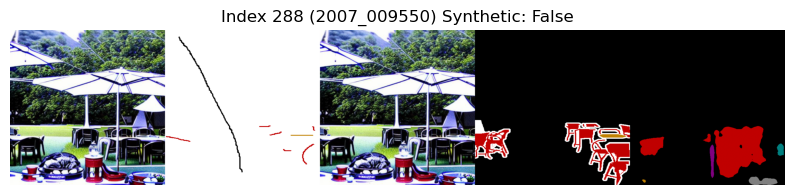

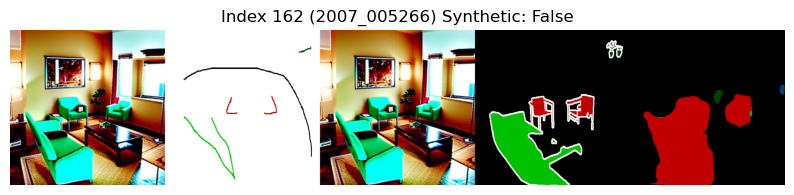

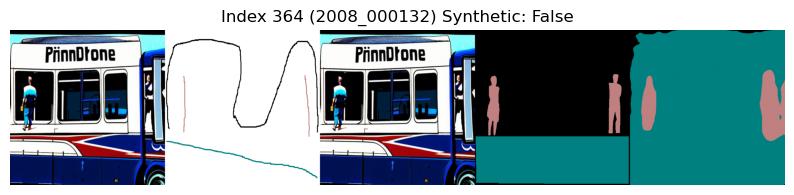

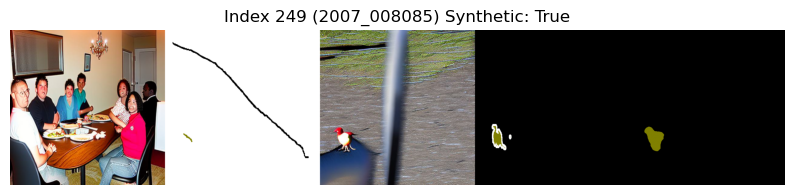

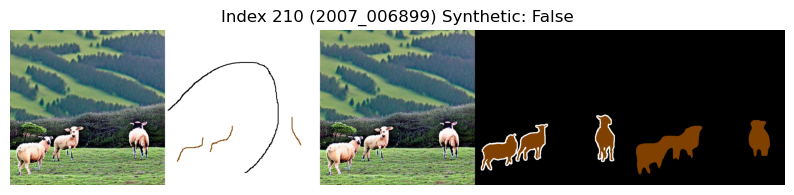

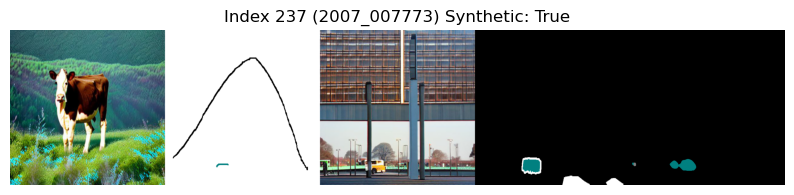

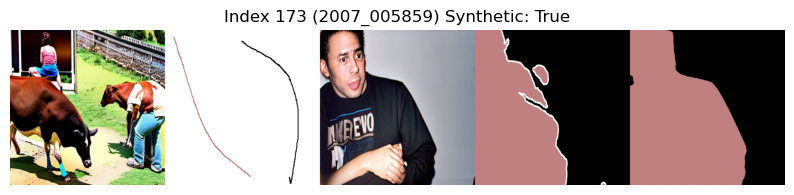

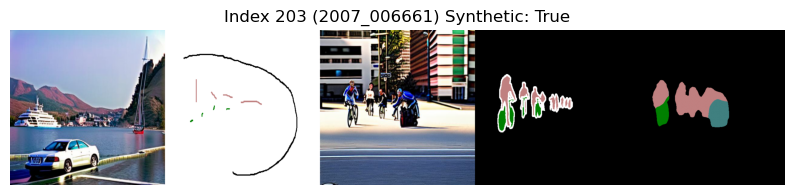

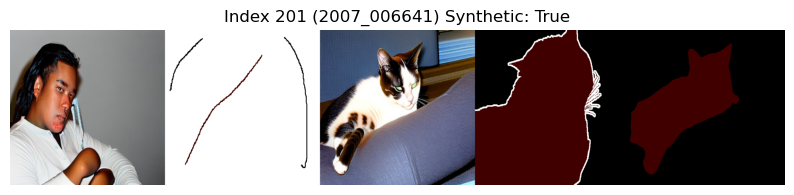

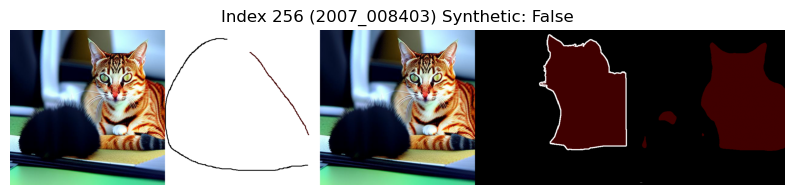

In [14]:
idxs = np.argsort(ious)
for i in idxs[:10]:
    img = torch.tensor(imgs[i])
    img = np.moveaxis(inv_tr(img).numpy(), 0, -1)
    scribble = decode_segmap(scribbles[i])
    target = decode_segmap(targets[i])
    pred = decode_segmap(preds[i])
    name = names[i].split('/')[-1].split('.')[0]
    if i % 2 == 0:
        img_orig = img
    else:
        img_orig = torch.tensor(imgs[i - 1])
        img_orig = np.moveaxis(inv_tr(img_orig).numpy(), 0, -1)
    plt.figure(figsize=(10,30))
    plt.title(f"Index {i} ({name}) Synthetic: {i % 2 == 1}")
    plt.imshow(np.concatenate([img_orig, scribble, img, target, pred], 1))
    plt.axis('off')
    plt.show()

In [15]:
scribbles[0]

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

In [8]:
data = voc_train[445]
img, target = data['image'].unsqueeze(0), data['label'].unsqueeze(0)
target[target==254]=255
img.to(gpu_ids[0])
with torch.no_grad():
    output = model(img)
target = target.numpy()
pred = output.cpu().numpy()
pred = np.argmax(pred, axis=1)

NameError: name 'voc_train' is not defined

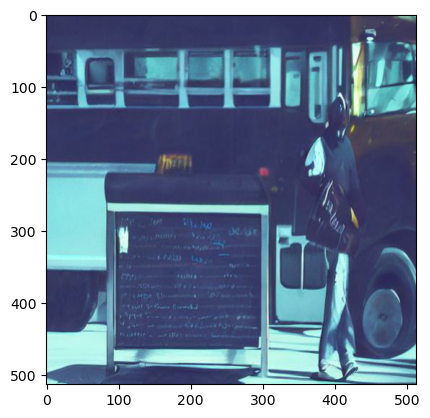

In [ ]:
plt.imshow(np.moveaxis(inv_tr(img.cpu()).numpy()[0], 0, -1))

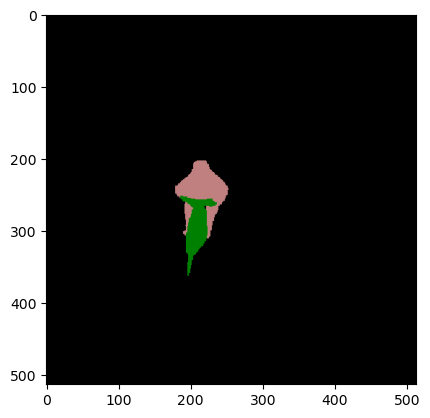

In [ ]:
decode_segmap(target[0], True)

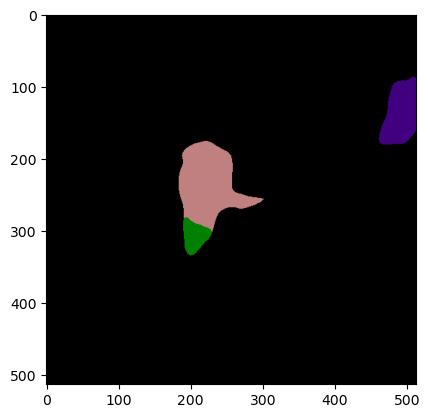

In [ ]:
decode_segmap(pred[0], True)

In [ ]:
img.min()

tensor(-2.1179)